# Energy Analysis
We will be using the new energy layer to analyze the following future PV options
- SHJ
- Perovskite (tandem?)
- 50-year PERC module (multiple uses)
- Recycled Si PERC (Fraunhofer)
- Cheap crap module
- CdTe?

We will use a literture-sourced global scale deployment schedule through 2050, then assume that capacity increases at a lower constant rate through 2100.

In [1]:
import numpy as np
import pandas as pd
import os,sys
from pathlib import Path
import matplotlib.pyplot as plt

cwd = os.getcwd() #grabs current working directory

testfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP' / 'EnergyAnalysis')
inputfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP')
baselinesfolder = str(Path().resolve().parent.parent /'PV_ICE' / 'baselines')
supportMatfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'baselines' / 'SupportingMaterial')

if not os.path.exists(testfolder):
    os.makedirs(testfolder)

In [2]:
#creating scenarios for identical power of multiple technologies
scennames = ['PV_ICE','PERC_50','SHJ','Perovskite','RecycledPERC']#,'CheapCrap','Repowered'] #
MATERIALS = ['glass','silver','silicon', 'copper', 'aluminium_frames'] #'encapsulant', 'backsheet',
moduleFile_m = os.path.join(baselinesfolder, 'baseline_modules_mass_US.csv')
moduleFile_e = os.path.join(baselinesfolder, 'baseline_modules_energy.csv')

We will be deploying based on power (not area) because each of these have different efficiencies, and those differences should be accounted for in the simulation. Additionally, we will run the installation compensation to simulate the required replacements for each module type.

In [3]:
#load in a baseline and materials for modification
import PV_ICE

sim1 = PV_ICE.Simulation(name='sim1', path=testfolder)
for scen in scennames:
    sim1.createScenario(name=scen, massmodulefile=moduleFile_m, energymodulefile=moduleFile_e)
    for mat in range (0, len(MATERIALS)):
        matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
        matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
        sim1.scenario[scen].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

path = C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP\EnergyAnalysis


## Module Types Creation
Starting modifications in 2022, using PV ICE baseline as historical for all modules

**NOTE: Currently have to modify all scenarios before extending the years to avoid errors.**

**NOTE: all dynamic values changed with PV ICE modify functions must feed in a Pandas Series**

In [4]:
sim1.scenario.keys()

dict_keys(['PV_ICE', 'PERC_50', 'SHJ', 'Perovskite', 'RecycledPERC'])

In [5]:
celltech_modeff = pd.read_csv(os.path.join(supportMatfolder, 'output-celltech-modeffimprovements.csv'),index_col=0) #pull in module eff
celltech_aguse = pd.read_csv(os.path.join(supportMatfolder, 'output-celltech-Agusageimprovements.csv'),index_col=0) #pull in Ag use

In [6]:
#glass-glass package mass per area calculation
#ITRPV 2022 Figs 36 and 38, we are assuming that the front and back glass heave equal thickness of 2.5mm
density_glass = 2500*1000 # g/m^3 
glassperm2 = (2.5/1000)* 2 * density_glass
print('The mass per module area of glass is '+str(glassperm2)+' g/m^2 for all modules with a glass-glass package')

The mass per module area of glass is 12500.0 g/m^2 for all modules with a glass-glass package


In [7]:
#time shift for modifications

In [8]:
sim_start_year = sim1.scenario['Perovskite'].dataIn_m.iloc[0,0]
mod_start_year = 2022
timeshift = mod_start_year - sim_start_year
print('Time shift: '+str(timeshift))

Time shift: 27


### PERC_50
This module represents current PERC technology (so good efficiency) if it were to have it's lifetime extended significantly. Glass-glass technology is assumed, expected decreases in silver usage and increases in module efficiency are derived from Zhang et al 2021, Gervais et al 2021 and ITRPV 2022. It is assumed that this module is no more recyclable than current technology (downcycle glass and recycle aluminium frames).

In [9]:
#module efficiency modify for PERC
sim1.modifyScenario('PERC_50', 'mod_eff', celltech_modeff.loc[2022:,'PERC'], start_year=2022) #changing module eff

In [10]:
#silver modify for PERC
sim1.scenario['PERC_50'].modifyMaterials('silver', 'mat_massperm2', celltech_aguse.loc[2022:,'PERC'], start_year=2022)
#old way
#sim1.scenario['PERC_50'].material['silver'].matdataIn_m.loc[timeshift:,'mat_massperm2'] = celltech_aguse.loc[2022:,'PERC'].values

In [11]:
#modify package to glass glass
sim1.scenario['PERC_50'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022) #

In [12]:
#Lifetime and Degradation
#values taken from lifetime vs recycling paper
#degradation rate:
sim1.modifyScenario('PERC_50', 'mod_degradation', 0.445, start_year=2022) #annual power degradation to reach 80% at 50 yrs
#T50
sim1.modifyScenario('PERC_50', 'mod_reliability_t50', 56.07, start_year=2022)
#t90
sim1.modifyScenario('PERC_50', 'mod_reliability_t90', 59.15, start_year=2022) 
#Mod Project Lifetime
sim1.modifyScenario('PERC_50', 'mod_lifetime', 50, start_year=2022) #project lifetime of 50 years


In [13]:
#Merchant Tail set high
sim1.modifyScenario('PERC_50', 'mod_MerchantTail', 100, start_year=2022) #all installations stay for merchant tail
#Change recycling?

### SHJ
This is a modern SHJ module with expected silver and module efficiency improvements taken from Zhang et al 2021, Gervais et al 2021, and ITPRV 2022. See PERC vs SHJ vs TOPCon for a more detailed evaluation.

In [14]:
#module efficiency modify for PERC
sim1.modifyScenario('SHJ', 'mod_eff', celltech_modeff.loc[2022:,'SHJ'], start_year=2022) #changing module eff
#sim1.scenario['SHJ'].dataIn_m.loc[timeshift:,'mod_eff'] = celltech_modeff.loc[2022:,'SHJ'].values

In [15]:
#modify silver usage for SHJ
sim1.scenario['SHJ'].modifyMaterials('silver', 'mat_massperm2', celltech_aguse.loc[2022:,'SHJ'], start_year=2022)

In [16]:
#modify package to glass glass
sim1.scenario['SHJ'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)

In [17]:
#Lifetime and Degradation
#values taken from lifetime vs recycling paper
#degradation rate:
sim1.modifyScenario('SHJ', 'mod_degradation', 0.5, start_year=2022) #annual power degradation
#Mod Project Lifetime
sim1.modifyScenario('SHJ', 'mod_lifetime', 30, start_year=2022) #project lifetime of 30 years
#T50
sim1.modifyScenario('SHJ', 'mod_reliability_t50', 28, start_year=2022)
#t90
sim1.modifyScenario('SHJ', 'mod_reliability_t90', 33, start_year=2022) 


In [18]:
#Merchant Tail set high
sim1.modifyScenario('SHJ', 'mod_MerchantTail', 50, start_year=2022) #50% stay for merchant tail, possibly change to DYNAMIC
#recycling?!?!

### Perovskite
This perovskite module uses current best module and cell efficiencies, has a prospective life of 15 years and 1.5% degradation rate, and is highly circular. This is a best case scenario for perovskites given current data.

In [19]:
#2022 module eff = 17.9% #https://www.nrel.gov/pv/assets/pdfs/champion-module-efficiencies-rev220401b.pdf
#2050 module eff = 32.5% # https://www.nrel.gov/pv/assets/pdfs/best-research-cell-efficiencies.pdf
idx_perovskite_eff = pd.RangeIndex(start=2022,stop=2051,step=1) #create the index
df_perovskite_eff = pd.DataFrame(index=idx_perovskite_eff, columns=['mod_eff_p'], dtype=float)
df_perovskite_eff.loc[2022] = 17.9
df_perovskite_eff.loc[2050] = 32.5
df_perovskite_eff.interpolate(inplace=True)

In [20]:
#module efficiency modify for PERC
sim1.modifyScenario('Perovskite', 'mod_eff', df_perovskite_eff['mod_eff_p'], start_year=2022) #changing module eff

In [21]:
#modify package to glass glass
sim1.scenario['Perovskite'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)

In [22]:
#Lifetime and Degradation
#values taken from lifetime vs recycling paper
#degradation rate:
sim1.modifyScenario('Perovskite', 'mod_degradation', 1.47, start_year=2022) #annual power degradation
#Mod Project Lifetime
sim1.modifyScenario('Perovskite', 'mod_lifetime', 15, start_year=2022) #project lifetime of 15 years
#T50
sim1.modifyScenario('Perovskite', 'mod_reliability_t50', 14, start_year=2022)
#t90
sim1.modifyScenario('Perovskite', 'mod_reliability_t90', 20, start_year=2022) 

In [23]:
#As Circular as possible
#100% collection rate
sim1.modifyScenario('Perovskite', 'mod_EOL_collection_eff', 100.0, start_year=2022) #100% collection
sim1.modifyScenario('Perovskite', 'mod_EOL_pg1_landfill', 0.0, start_year=2022) #100% collection
sim1.modifyScenario('Perovskite', 'mod_EOL_pb1_landfill', 0.0, start_year=2022) #100% collection

# remanufacturing
sim1.modifyScenario('Perovskite', 'mod_EOL_pg3_reMFG', 100.0, start_year=2022) #all modules attempt remfg
sim1.modifyScenario('Perovskite', 'mod_EOL_sp_reMFG_recycle', 100.0, start_year=2022) # recycle if can't remfg
sim1.modifyScenario('Perovskite', 'mod_EOL_pb3_reMFG', 100.0, start_year=2022) # remfg bad mods too
sim1.modifyScenario('Perovskite', 'mod_EOL_reMFG_yield', 98.0, start_year=2022) # REMFG YIELD 98%

#set all other paths to 0
sim1.modifyScenario('Perovskite', 'mod_EOL_pg0_resell', 0.0, start_year=2022) # 
sim1.modifyScenario('Perovskite', 'mod_EOL_pg1_landfill', 0.0, start_year=2022) # 
sim1.modifyScenario('Perovskite', 'mod_EOL_pg2_stored', 0.0, start_year=2022) #
sim1.modifyScenario('Perovskite', 'mod_EOL_pg4_recycled', 0.0, start_year=2022) # 
sim1.modifyScenario('Perovskite', 'mod_EOL_pb1_landfill', 0.0, start_year=2022) # 
sim1.modifyScenario('Perovskite', 'mod_EOL_pb2_stored', 0.0, start_year=2022) # 
sim1.modifyScenario('Perovskite', 'mod_EOL_pb4_recycled', 0.0, start_year=2022) # 
sim1.modifyScenario('Perovskite', 'mod_Repair', 0.0, start_year=2022) #
sim1.modifyScenario('Perovskite', 'mod_MerchantTail', 0.0, start_year=2022) #


#Material Remanufacture
#Glass
#mfg scrap
sim1.scenario['Perovskite'].modifyMaterials('glass', 'mat_MFG_scrap_Recycled', 100.0, start_year=2022) #send mfg scrap to recycle
sim1.scenario['Perovskite'].modifyMaterials('glass', 'mat_MFG_scrap_Recycling_eff', 99.0, start_year=2022) #99% yield
sim1.scenario['Perovskite'].modifyMaterials('glass', 'mat_MFG_scrap_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['Perovskite'].modifyMaterials('glass', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
#eol
sim1.scenario['Perovskite'].modifyMaterials('glass', 'mat_PG3_ReMFG_target', 100.0, start_year=2022) #send all to remfg
sim1.scenario['Perovskite'].modifyMaterials('glass', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send none to recycle
sim1.scenario['Perovskite'].modifyMaterials('glass', 'mat_ReMFG_yield', 99.0, start_year=2022) #99% yeild
sim1.scenario['Perovskite'].modifyMaterials('glass', 'mat_Recycling_yield', 99.0, start_year=2022) #99% yeild


#silicon Recycle (or should it be remfg?)
#mfg scrap
sim1.scenario['Perovskite'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled', 100.0, start_year=2022) #send mfg scrap to recycle
sim1.scenario['Perovskite'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycling_eff', 98.0, start_year=2022) #98% yield
sim1.scenario['Perovskite'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['Perovskite'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
#eol
sim1.scenario['Perovskite'].modifyMaterials('silicon', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['Perovskite'].modifyMaterials('silicon', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send to recycle
sim1.scenario['Perovskite'].modifyMaterials('silicon', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['Perovskite'].modifyMaterials('silicon', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['Perovskite'].modifyMaterials('silicon', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
sim1.scenario['Perovskite'].modifyMaterials('silicon', 'mat_ReMFG_yield', 0.0, start_year=2022) #99% yeild

#aluminium_frames recycle
#mfg scrap
sim1.scenario['Perovskite'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled', 100.0, start_year=2022) #send mfg scrap to recycle
sim1.scenario['Perovskite'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycling_eff', 99.0, start_year=2022) #98% yield
sim1.scenario['Perovskite'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['Perovskite'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
#eol
sim1.scenario['Perovskite'].modifyMaterials('aluminium_frames', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['Perovskite'].modifyMaterials('aluminium_frames', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send to recycle
sim1.scenario['Perovskite'].modifyMaterials('aluminium_frames', 'mat_Recycling_yield', 99.0, start_year=2022) #99% yeild
sim1.scenario['Perovskite'].modifyMaterials('aluminium_frames', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['Perovskite'].modifyMaterials('aluminium_frames', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
sim1.scenario['Perovskite'].modifyMaterials('aluminium_frames', 'mat_ReMFG_yield', 0.0, start_year=2022) #0% yeild


#### Recycled PERC
This module is based on the recent test from Fraunhofer ISE in which an old module was dissassembled, and the silicon wafer cleaned, put into a Cz ingot growth process and made using standard PERC processing, creating a 19% efficient module.
https://www.ise.fraunhofer.de/en/press-media/press-releases/2022/solar-cells-from-recycled-silicon.html

In [24]:
#https://www.ise.fraunhofer.de/en/press-media/press-releases/2022/solar-cells-from-recycled-silicon.html
#lets assume this gets slightly better over time
idx_RePerc_eff = pd.RangeIndex(start=2022,stop=2051,step=1) #create the index
df_RePerc_eff = pd.DataFrame(index=idx_RePerc_eff, columns=['mod_eff_RePerc'], dtype=float)
df_RePerc_eff.loc[2022] = 19.7
df_RePerc_eff.loc[2050] = 22.2
df_RePerc_eff.interpolate(inplace=True)

In [25]:
#module efficiency
sim1.modifyScenario('RecycledPERC', 'mod_eff', df_RePerc_eff['mod_eff_RePerc'], start_year=2022)

In [26]:
#Lifetime and Degradation
#values taken from lifetime vs recycling paper
#degradation rate:
sim1.modifyScenario('RecycledPERC', 'mod_degradation', 0.8, start_year=2022) #slightly higher than current std
#Mod Project Lifetime
sim1.modifyScenario('RecycledPERC', 'mod_lifetime', 20, start_year=2022) #project lifetime of 20 years
#T50
sim1.modifyScenario('RecycledPERC', 'mod_reliability_t50', 21, start_year=2022)
#t90
sim1.modifyScenario('RecycledPERC', 'mod_reliability_t90', 26, start_year=2022) 

In [27]:
#silicon recycled
#mfg scrap
sim1.scenario['RecycledPERC'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled', 100.0, start_year=2022) #send mfg scrap to recycle
sim1.scenario['RecycledPERC'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycling_eff', 98.0, start_year=2022) #98% yield
sim1.scenario['RecycledPERC'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['RecycledPERC'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
#eol
sim1.scenario['RecycledPERC'].modifyMaterials('silicon', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['RecycledPERC'].modifyMaterials('silicon', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send to recycle
sim1.scenario['RecycledPERC'].modifyMaterials('silicon', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['RecycledPERC'].modifyMaterials('silicon', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['RecycledPERC'].modifyMaterials('silicon', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop

#aluminium_frames recycle
#mfg scrap
sim1.scenario['RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled', 100.0, start_year=2022) #send mfg scrap to recycle
sim1.scenario['RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycling_eff', 99.0, start_year=2022) #98% yield
sim1.scenario['RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
#eol
sim1.scenario['RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send to recycle
sim1.scenario['RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_Recycling_yield', 99.0, start_year=2022) #99% yeild
sim1.scenario['RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop

In [28]:
#the cool feature of this module was that the wafer was directly put into the Cz process
#therefore, we need to modify the recycling energy to reflect this
#this energy profile is output by the (baseline development) Energy Silicon Manufacturing journal.
altHQRecycle_e = pd.read_csv(os.path.join(supportMatfolder, 'output_energy_silicon_eol_recycleHQ_ALT.csv'), index_col=0)

In [29]:
altHQRecycle_e

E_MFG_kWhpkg  E_mfgFuelFraction
1995    600.817735           0.064489
1996    527.042434           0.072326
1997    485.167804           0.077357
1998    432.693843           0.085473
1999    380.620553           0.095834
2000    269.697933           0.075408
2001    236.759317           0.066235
2002    204.221370           0.054188
2003    172.084094           0.037719
2004    159.669155           0.030097
2005    140.254886           0.022532
2006    130.586287           0.022463
2007    121.318358           0.022639
2008    112.451100           0.023120
2009    103.984511           0.023976
2010     95.918593           0.025298
2011     88.253345           0.027195
2012     88.388767           0.027307
2013     88.924859           0.027745
2014     89.861622           0.028498
2015     91.199054           0.029547
2016     76.337157           0.037576
2017     61.875930           0.049814
2018     62.915373           0.053028
2019     64.355487           0.056410
2020     74.096270           0.053503
2021     77.837724           0.055738
2022     77.837724           0.055738
2023     77.837724           0.055738
2024     77.837724           0.055738
2025     77.837724           0.055738
2026     77.837724           0.055738
2027     77.837724           0.055738
2028     77.837724           0.055738
2029     77.837724           0.055738
2030     77.837724           0.055738
2031     77.837724           0.055738
2032     77.837724           0.055738
2033     77.837724           0.055738
2034     77.837724           0.055738
2035     77.837724           0.055738
2036     77.837724           0.055738
2037     77.837724           0.055738
2038     77.837724           0.055738
2039     77.837724           0.055738
2040     77.837724           0.055738
2041     77.837724           0.055738
2042     77.837724           0.055738
2043     77.837724           0.055738
2044     77.837724           0.055738
2045     77.837724           0.055738
2046     77.837724           0.055738
2047     77.837724           0.055738
2048     77.837724           0.055738
2049     77.837724           0.055738
2050     77.837724           0.055738

In [30]:
sim1.scenario['RecycledPERC'].modifyMaterialEnergy('silicon', 'e_mat_Recycled_HQ', altHQRecycle_e.loc[2022:,'E_MFG_kWhpkg'], start_year=2022)
sim1.scenario['RecycledPERC'].modifyMaterialEnergy('silicon', 'e_mat_Recycled_HQ_fuelfraction', altHQRecycle_e.loc[2022:,'E_mfgFuelFraction'], start_year=2022)


In [31]:
sim1.scenario['RecycledPERC'].material['silicon'].matdataIn_e.iloc[25:30,]

year  e_mat_extraction  e_mat_MFG  e_mat_MFG_fuelfraction  \
25  2020            0.0062     169.06                    0.22   
26  2021            0.0062     170.73                    0.21   
27  2022            0.0062     169.05                    0.20   
28  2023            0.0062     168.80                    0.20   
29  2024            0.0062     169.09                    0.20   

    e_mat_MFGScrap_LQ  e_mat_MFGScrap_HQ  e_mat_Landfill  \
25               24.5              600.0            0.09   
26               24.5              600.0            0.09   
27               24.5              600.0            0.09   
28               24.5              600.0            0.09   
29               24.5              600.0            0.09   

    e_mat_Landfill_fuelfraction  e_mat_EoL_ReMFG_clean  e_mat_Recycled_LQ  \
25                          0.0                    0.4                1.6   
26                          0.0                    0.4                1.6   
27                          0.0                    0.4                1.6   
28                          0.0                    0.4                1.6   
29                          0.0                    0.4                1.6   

    e_mat_Recycled_HQ  e_mat_Recycled_HQ_fuelfraction  
25         138.380000                        0.200000  
26         143.040000                        0.190000  
27          77.837724                        0.055738  
28          77.837724                        0.055738  
29          77.837724                        0.055738

#### Cheap Crap

#### Repowered

### Modify Years 2000 to 2100
We do this after we modify the baselines to propogate the modified 2050 values forward

In [32]:
#trim to start in 2000, this trims module and materials
#had to specify and end year, cannot use to extend
sim1.trim_Years(startYear=2000, endYear=2100)

Data trimed, years now encompass  2000  to  2100
Data trimed, years now encompass  2000  to  2100
Data trimed, years now encompass  2000  to  2100
Data trimed, years now encompass  2000  to  2100
Data trimed, years now encompass  2000  to  2100


In [33]:
#check
sim1.scenario['SHJ'].material['glass'].matdataIn_e

year  e_mat_extraction  e_mat_MFG  e_mat_MFG_fuelfraction  \
0    2000            0.0062   4.434640               80.005988   
1    2001            0.0062   4.382279               79.998397   
2    2002            0.0062   4.318724               80.200079   
3    2003            0.0062   4.255168               80.409933   
4    2004            0.0062   4.191613               80.628330   
..    ...               ...        ...                     ...   
96   2096            0.0062   3.512724               86.798744   
97   2097            0.0062   3.512724               86.798744   
98   2098            0.0062   3.512724               86.798744   
99   2099            0.0062   3.512724               86.798744   
100  2100            0.0062   3.512724               86.798744   

     e_mat_MFGScrap_LQ  e_mat_MFGScrap_HQ  e_mat_Landfill  \
0                  1.4                1.4            0.09   
1                  1.4                1.4            0.09   
2                  1.4                1.4            0.09   
3                  1.4                1.4            0.09   
4                  1.4                1.4            0.09   
..                 ...                ...             ...   
96                 1.4                1.4            0.09   
97                 1.4                1.4            0.09   
98                 1.4                1.4            0.09   
99                 1.4                1.4            0.09   
100                1.4                1.4            0.09   

     e_mat_Landfill_fuelfraction  e_mat_EoL_ReMFG_clean  e_mat_Recycled_LQ  \
0                           78.0                   0.61                1.4   
1                           78.0                   0.61                1.4   
2                           78.0                   0.61                1.4   
3                           78.0                   0.61                1.4   
4                           78.0                   0.61                1.4   
..                           ...                    ...                ...   
96                          78.0                   0.61                1.4   
97                          78.0                   0.61                1.4   
98                          78.0                   0.61                1.4   
99                          78.0                   0.61                1.4   
100                         78.0                   0.61                1.4   

     ...  e_mod_MFG  e_mod_Install  e_mod_OandM  e_mod_Repair  e_mod_Demount  \
0    ...        NaN            NaN          NaN           NaN            NaN   
1    ...        NaN            NaN          NaN           NaN            NaN   
2    ...        NaN            NaN          NaN           NaN            NaN   
3    ...        NaN            NaN          NaN           NaN            NaN   
4    ...        NaN            NaN          NaN           NaN            NaN   
..   ...        ...            ...          ...           ...            ...   
96   ...        NaN            NaN          NaN           NaN            NaN   
97   ...        NaN            NaN          NaN           NaN            NaN   
98   ...        NaN            NaN          NaN           NaN            NaN   
99   ...        NaN            NaN          NaN           NaN            NaN   
100  ...        NaN            NaN          NaN           NaN            NaN   

     e_mod_Demount_fuelfraction  e_mod_Resell_Certify  e_mod_Store  \
0                           NaN                   NaN          NaN   
1                           NaN                   NaN          NaN   
2                           NaN                   NaN          NaN   
3                           NaN                   NaN          NaN   
4                           NaN                   NaN          NaN   
..                          ...                   ...          ...   
96                          NaN                   NaN          NaN   
97                   

### Apply deployment curve
For the full derivation of the deployment curve, see the "PV Installations - Global" development journal. Essentially, the projection is 2000-2021 IRENA historical installation data, 2022 through 2050 is a quadratic fit to achieve 50 TW in 2050, and from 2050 to 2100 is a linear increase to approx 60 TW based on 2000-2021 global increase in electricity capacity (219.32 GW/year).

This is the deployment curve applied to all PV technologies - however, it will be modified for each PV tech using the installation compensation method, increasing it for any replacement modules required to maintain capacity.

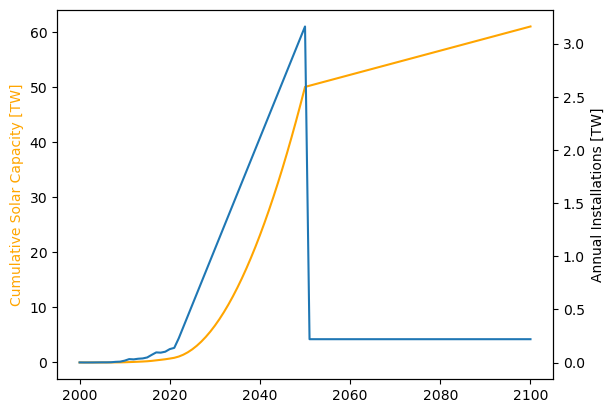

In [34]:
global_projection = pd.read_csv(os.path.join(supportMatfolder,'output-globalInstallsProjection.csv'), index_col=0)

fig, ax1 = plt.subplots()

ax1.plot(global_projection['World_cum']/1e6, color='orange')
ax1.set_ylabel('Cumulative Solar Capacity [TW]', color='orange')
ax2 = ax1.twinx()
ax2.plot(global_projection['World_annual_[MWdc]']/1e6)
ax2.set_ylabel('Annual Installations [TW]')
plt.show()


In [35]:
#deployment projection for all scenarios
sim1.modifyScenario(scenarios=None,stage='new_Installed_Capacity_[MW]', value= global_projection['World_annual_[MWdc]'], start_year=2000)
#for scen in scennames:
#    sim1.scenario[scen].dataIn_m.loc[0:len(global_projection.index-1),'new_Installed_Capacity_[MW]'] = global_projection['World_annual_[MWdc]'].values

# Calculate Mass flow
Can just calc mass here (exclude energy) because we're going to immediately do Install Compensation.

In [36]:
sim1.calculateMassFlow()

>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surpl

In [37]:
ii_yearly, ii_cumu = sim1.aggregateResults() #have to do this to get auto plots

Text(0.5, 1.0, 'Effective Capacity: No Replacements')

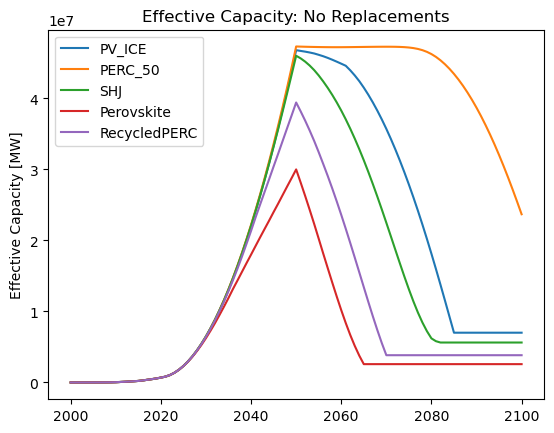

In [38]:
effective_capacity = ii_yearly.filter(like='ActiveCapacity')
plt.plot(effective_capacity)
plt.legend(scennames)
plt.ylabel('Effective Capacity [MW]')
plt.title('Effective Capacity: No Replacements')

# Installation Compensation
Make the installations always match up to the cumulative capacity deployment schedule. (i.e. not the PV ICE baseline)

#### Bifacial Factors

In [39]:
bifiFactors = {'PERC_50':0.7,
               'SHJ':0.9,
               'Perovskite': 0.0,
               'RecycledPERC':0.6,
              'PV_ICE':0.0} 

#MAY NEED TO CHANGE TO BE DYNAMIC
#              'TOPCon':0.8, # ITRPV 2022, Fig. 58
#               'Repowered':0.56

In [40]:
#PV ICE currently set up to read in a csv of bifi factors, so generate files to read in 
idx_temp = pd.RangeIndex(start=2000,stop=2101,step=1) #create the index
df_temp = pd.DataFrame(index=idx_temp, columns=['bifi'], dtype=float)
bifiPathDict={}

for f in bifiFactors.keys(): #loop over module types
    bifi = df_temp.copy() #copy of df
    bifi['bifi'] = bifiFactors[f] #assign column
    bifipath = os.path.join(testfolder,'bifi_'+str(f)+'.csv') #create file path
    bifi.to_csv(path_or_buf=bifipath, index_label='year') #create file
    bifiPathDict[str(f)] = bifipath
    #append bifi path to dict? or list?


In [41]:
#currently takes 15 mins to run with 5 mateirals and 5 scenarios

for row in range (0,len(sim1.scenario['PV_ICE'].dataIn_m)): #loop over length of years
    print(row)
    for scen in scennames: #loop over scenarios
        print(scen)
        Under_Installment = global_projection.iloc[row,0] - ((sim1.scenario[scen].dataOut_m['Installed_Capacity_[W]'][row])/1e6)  # MWATTS
        sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed
        sim1.calculateFlows(scenarios=[scen], bifacialityfactors=bifiPathDict[scen]) #calculate flows for that scenario with it's bifi factor


0
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213468789.114702  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121295.856909094  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33071992.272860732  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115382017.01697423  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
1
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213468789.114702  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121295.856909094  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33071992.272860732  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115382017.01697423  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
2
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213468789.114702  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121295.856909094  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33071992.272860732  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115382017.01697423  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
3
PV_ICE


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213468789.114702  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121295.856909094  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33071992.272860732  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115382017.01697423  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
4
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213468789.114702  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121295.856909094  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33071992.272860732  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115382017.01697423  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
5
PV_ICE


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213468789.114702  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121295.856909094  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33071992.272860732  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115382017.01697423  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
6
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213468789.114702  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121295.856909094  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33071992.272860732  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115382017.01697423  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
7
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213468789.114702  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121295.856909094  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33071992.272860732  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115382017.01697423  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
8
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213468789.114702  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121295.856909094  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33071992.272860732  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115382017.01697423  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
9
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213468789.114702  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121295.856909094  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33071992.272860732  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115382017.01697423  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
10
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213468789.114702  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121295.856909094  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33071992.272860732  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115382017.01697423  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
11
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213468789.114702  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121295.856909094  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33071992.272860732  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115382017.01697423  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
12
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213468789.114702  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121295.856909094  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33071992.272860732  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115382017.01697423  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
13
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213468789.114702  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121295.856909094  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33071992.272860732  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115382017.01697423  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
14
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213468789.114702  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121295.856909094  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33071992.272860732  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115382017.01697423  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
15
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213468789.114702  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121295.856909094  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33071992.272860732  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115382017.01697423  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
16
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213468789.114702  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121295.856909094  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33071992.272860732  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115382017.01697423  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
17
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213468789.114702  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121295.856909094  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33071992.272860732  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115382017.01697423  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
18
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213468789.114702  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121295.856909094  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33071992.272860732  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115382017.01697423  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
19
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213509497.9410162  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121310.711476736  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33073913.392222177  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115388501.43015832  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
20
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213674995.2893658  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121371.101121398  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33081280.374347925  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115413782.2712441  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
21
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213880569.1642702  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121446.114608813  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33089979.108808607  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115442524.90704206  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
22
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213880569.1642702  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121446.114608813  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33089979.108808607  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115442524.90704206  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
23
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213880569.1642702  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121446.114608813  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33089979.108808607  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115442524.90704206  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
24
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213880569.1642702  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121446.114608813  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33089979.108808607  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115442524.90704206  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
25
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213880569.1642702  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121446.114608813  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33089979.108808607  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115442524.90704206  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
26
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213880569.1642702  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121446.114608813  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33089979.108808607  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115442524.90704206  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
27
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213880569.1642702  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121446.114608813  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33089979.108808607  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115442524.90704206  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
28
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213880569.1642702  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121446.114608813  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33089979.108808607  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115442524.90704206  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
29
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213880569.1642702  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121446.114608813  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33089979.108808607  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115442524.90704206  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
30
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213880569.1642702  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121446.114608813  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33089979.108808607  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115442524.90704206  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
31
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213880569.1642702  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121446.114608813  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33089979.108808607  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115442524.90704206  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
32
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213880569.1642702  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121446.114608813  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33089979.108808607  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115442524.90704206  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
33
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213880569.1642702  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121446.114608813  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33089979.108808607  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115442524.90704206  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
34
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213880569.1642702  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121446.114608813  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33089979.108808607  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115442524.90704206  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
35
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1213880569.1642702  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9121446.114608813  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33089979.108808607  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  115442524.90704206  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
36
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1225053397.6155577  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9125523.056908999  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33390672.199492723  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  116485501.06616676  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
37
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1243209383.3631816  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9132148.139055273  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  33879302.22658677  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  118180350.34831049  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
38
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1266465072.5836885  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9140634.092591215  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  34505180.00661281  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  120351253.58259466  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
39
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1296106923.61503  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9151450.343538977  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  35302927.84988017  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  123118300.80548948  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
40
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1333320024.0225096  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9165029.327932563  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  36304439.88635772  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  126592119.15876801  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
41
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1376716793.809891  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9180864.72066308  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  37472372.3297822  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  130643178.96592422  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
42
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1427230171.7211387  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9199296.949174367  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  38831833.25691006  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  135358569.44273913  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
43
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1485640569.6970809  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9220610.784190895  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  40403825.80759236  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  140811141.5286255  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
44
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1551337943.5835538  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9244583.621845797  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  42171931.9312908  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  146943948.00457188  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
45
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1622508517.3549175  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9270553.618968898  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  44087337.67535798  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  153587674.07612044  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
46
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1701550976.710415  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9299396.051076578  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  46214598.601497  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  160966235.4695756  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
47
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1785793676.4898903  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9330136.04030223  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  48481813.02036204  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  168830235.8731769  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
48
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1876392614.8749864  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9363195.408023158  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  50920092.18257145  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  177287586.95393884  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
49
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1974454326.692183  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9398977.926539313  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  53559216.1369619  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  186441583.0073292  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
50
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2078209079.7297988  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9436837.824178344  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  56351556.27715734  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  196127020.6998442  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
51
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2074834138.1645312  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  9370878.592270352  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  56263431.03336332  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  196017602.0345192  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
52
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2070259161.9373925  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  10263463.152680272  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  56169118.45204302  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  195900501.0050396  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
53
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2065249919.3264844  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  11369169.629103819  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  56069141.5560737  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  195776367.01063192  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
54
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2059834860.9952886  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  12649621.046357851  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  55963246.22050277  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  195644884.522942  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
55
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2053508589.416326  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  14571717.870821679  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  55850445.283716284  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  195504827.85564426  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
56
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2047583634.5638971  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  15895729.830755455  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  55732606.436400816  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  195358515.98356774  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<



C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
57
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2042826725.9070497  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  15903469.502085118  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  55610974.75373375  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  195207494.82543314  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
58
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2038502343.8979132  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  15291004.463792278  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  55484538.025025934  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  195050507.59331146  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<



C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
59
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2034936391.5853353  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  13762225.71404239  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  55354060.07593233  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  194888502.67361397  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
60
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2032552985.944318  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  10935493.82286147  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  55220629.79227716  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  194722832.0561731  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
61
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2031250203.0003364  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  7510431.840004065  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  55084253.40179198  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  194553503.4735071  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
62
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2031523430.211906  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  7336961.468611406  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  54946304.0195337  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  194382221.82208383  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
63
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2033385057.1362875  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  7164070.70103232  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  54908979.08642202  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  194209298.35521874  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
64
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2036861792.8560445  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  6991769.283356522  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  54997555.84596585  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  194034999.34350663  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
65
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2042206547.872975  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  6820149.502110014  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  55136406.40129682  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  193860405.90965208  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
66
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2057204596.5227804  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  6652052.188009447  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  55535054.97558121  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  193722182.7371079  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
67
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2071041930.8177965  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  6483531.331609716  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  55902465.373403385  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  194372598.88056776  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
68
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2083811648.3222513  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  6314620.904021889  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  56241143.11916525  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  195533061.69866186  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
69
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2095525756.86082  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  6145325.286876712  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  56551411.37811814  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  196594984.11675096  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
70
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2106139610.3567903  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  5975628.188911912  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  56832068.59536014  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  197554198.45305127  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
71
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2115950894.7561011  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  5805638.235121634  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  57091126.35967807  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  198438493.49407062  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
72
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2125169612.706328  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  5635432.055043406  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  57334236.44899253  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  199267472.84830683  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
73
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2133757547.557007  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  5464995.703499466  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  57560370.34283587  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  200037569.01667166  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
74
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2141904211.4393044  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  5294398.333079716  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  57774628.360137284  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  200766472.831485  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
75
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2149831733.355044  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  5123720.998203599  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  57982988.634041816  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  201474919.88840756  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
76
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2157633247.8025155  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  4952997.683459467  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  58187957.68295366  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  202171604.23136297  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
77
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2165549836.7100744  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  4782316.359150975  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  58396023.71802382  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  202879030.69919032  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
78
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2173669409.030791  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  4611709.103075693  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  58609552.62313854  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  203605405.53461707  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
79
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2182058684.6781106  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  4441200.261193874  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  58830340.02391514  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  204356956.9975121  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
80
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2190831161.784214  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  4270831.2487423215  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  59061440.48297399  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  205144280.06357762  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
81
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2203101119.0535274  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  4101738.459664609  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  59386668.23705644  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  206258090.5936855  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
82
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2214583971.194117  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  3932358.457531762  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  59690712.718265675  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  207298425.37970906  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
83
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2225367228.063466  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  3762723.1745121866  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  59975929.06967279  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  208273453.40906653  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
84
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2235516849.4357886  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  3592856.6791928774  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  60244092.459352426  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  209189331.9831313  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
85
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2245089579.8327794  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  3422779.677534  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  60496730.04631193  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  210051358.16553807  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
86
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2163922093.2682943  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  3219591.7558899955  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  58307286.25643356  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  202442845.00535634  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
87
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2066625012.507594  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  3010518.178241331  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  55683748.49012957  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  193328644.8764403  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
88
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1953747540.6244583  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2795759.347668806  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  52640897.38870205  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  182760025.5231185  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
89
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1826711304.894937  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2575834.0130641735  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  49216993.04907273  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  170869694.91298828  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
90
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1687418571.2517607  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2351436.3073841063  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  45463230.94292635  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  157835228.3149086  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
91
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1537821482.199932  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  2123278.5634447224  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  41432148.86459527  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  143838856.94282934  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
92
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1380161114.3153193  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1892178.545514925  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  37184060.658957325  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  129089783.81544831  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
93
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1216320830.1864266  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1658823.4887596616  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  32769653.054094452  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  113763819.58692193  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<



C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
94
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1047940274.7748616  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1423811.6962792128  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  28233053.632675588  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  98014024.03184904  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
95
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  876464611.9143604  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  1187670.5054071944  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  23613155.928384356  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  81975302.2399469  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
96
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  708020646.2189592  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  952635.5746435809  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  19074849.953042194  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  66219587.37674422  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
97
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  535250103.7371803  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  716021.8848403695  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  14420103.297379019  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  50059989.42713344  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
98
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  359191391.0755074  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  478208.3484490014  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  9676862.483016584  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  33593442.962227106  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
99
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  Perovskite  =  180601310.7626464  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  Perovskite  =  239471.1211677723  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  Perovskite  =  4865495.252320804  tonnes.
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  Perovskite  =  16890594.998404972  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
100
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_50
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_20364\2875697581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames


>>>> Calculating Energy Flows <<<<

Working on Scenario:  RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames


In [42]:
sim1.scenario['SHJ'].dataOut_m['irradiance_stc'].head(2)

0    1090.0
1    1090.0
Name: irradiance_stc, dtype: float64

In [43]:
sim1.scenario['PV_ICE'].dataOut_m['irradiance_stc'].head(2)

0    1000.0
1    1000.0
Name: irradiance_stc, dtype: float64

In [44]:
sim1.scenario['PERC_50'].dataOut_m['irradiance_stc'].head(2)

0    1070.0
1    1070.0
Name: irradiance_stc, dtype: float64

In [45]:
sim1.scenario['Perovskite'].dataOut_m['irradiance_stc'].head(2)

0    1000.0
1    1000.0
Name: irradiance_stc, dtype: float64

In [46]:
sim1.scenario['RecycledPERC'].dataOut_m['irradiance_stc'].head(2)

0    1060.0
1    1060.0
Name: irradiance_stc, dtype: float64

In [47]:
cc_yearly, cc_cumu = sim1.aggregateResults() #have to do this to get auto plots

In [48]:
sim1.plotMetricResults()

[]


# RESULTS: Effective Capacity and Replacements

In [49]:
#https://www.learnui.design/tools/data-color-picker.html#palette
#color pallette - modify here for all graphs below
colorpalette=['#451ab0','#c4008e','#fe1561','#ff7937','#ffc229']
import matplotlib as mpl #import matplotlib
from cycler import cycler #import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=colorpalette) #reset the default color palette of mpl

plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (8, 4)

scennames_labels = ['PV_ICE','PERC_50','SHJ','Perovskite','Recycled\nPERC']

(0.0, 64.01425956655)

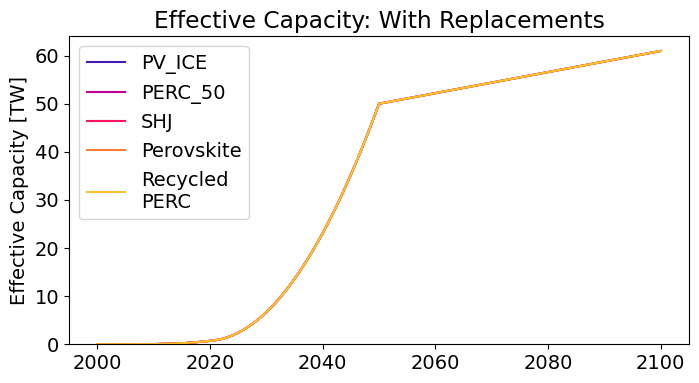

In [50]:
effective_capacity = cc_yearly.filter(like='ActiveCapacity')
plt.plot(effective_capacity/1e6)
plt.legend(scennames_labels)
plt.ylabel('Effective Capacity [TW]')
plt.title('Effective Capacity: With Replacements')
plt.ylim(0,)

(0.0, 264.9415075728642)

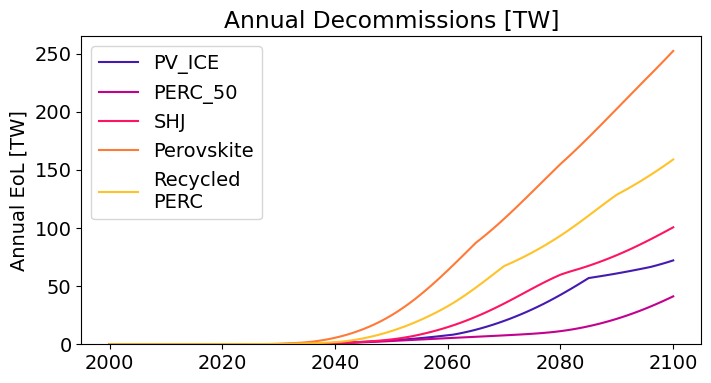

In [51]:
annual_EoL = cc_yearly.filter(like='DecommisionedCapacity')
plt.plot(annual_EoL/1e6)
plt.legend(scennames_labels)
plt.ylabel('Annual EoL [TW]')
plt.title('Annual Decommissions [TW]')
plt.ylim(0,)

(0.0, 6.2388876601740275)

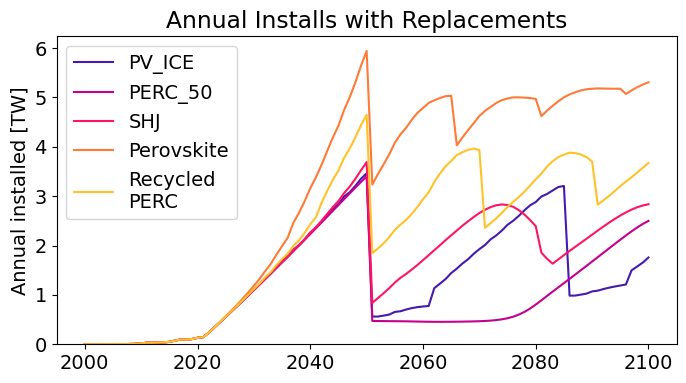

In [52]:
annual_installs = cc_yearly.filter(like='newInstalled')
plt.plot(annual_installs/1e6)
plt.legend(scennames_labels)
plt.ylabel('Annual installed [TW]')
plt.title('Annual Installs with Replacements')
plt.ylim(0,)

(0.0, 328.95576713941426)

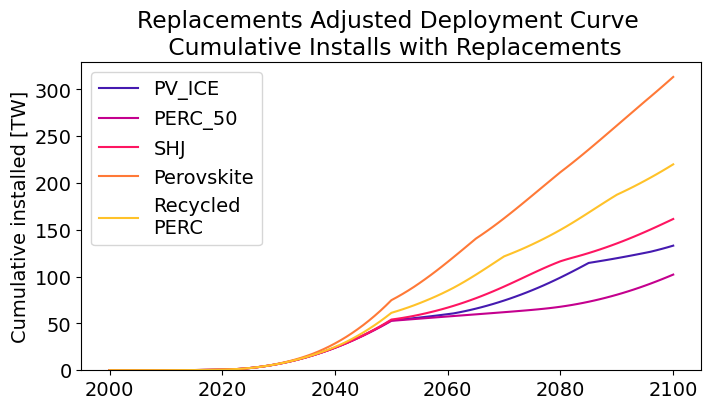

In [53]:
cumu_installs_annually = cc_cumu.filter(like='newInstalled')
plt.plot(cumu_installs_annually/1e6)
plt.legend(scennames_labels)
plt.ylabel('Cumulative installed [TW]')
plt.title('Replacements Adjusted Deployment Curve \n Cumulative Installs with Replacements')
plt.ylim(0,)

Text(0.5, 1.0, 'Cumulative Installs with Replacements')

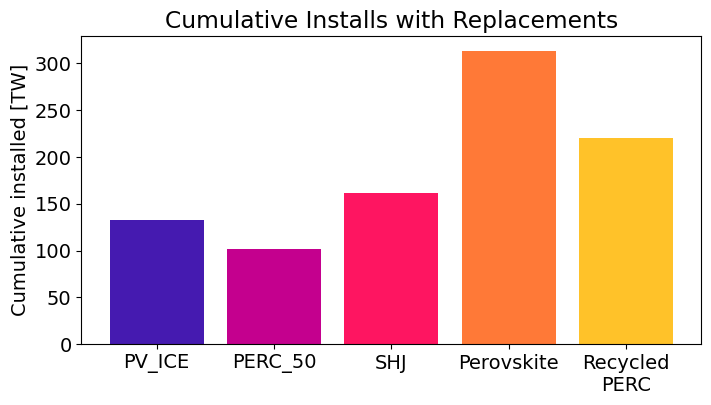

In [54]:
cumu_installs = cc_cumu.filter(like='newInstalled')
plt.bar(scennames, cumu_installs.loc[2100]/1e6, tick_label=scennames_labels, color=colorpalette)
#plt.legend(scennames)
plt.ylabel('Cumulative installed [TW]')
plt.title('Cumulative Installs with Replacements')

In [55]:
cumulative_nameplate_installs = global_projection.loc[2100,'World_cum'] #MW
print('The nameplate installations for energy transition and through 2100 are '+str(cumulative_nameplate_installs/1e6)+' TW.')

The nameplate installations for energy transition and through 2100 are 60.966 TW.


In [56]:
global_projection['World_annual_[MWdc]'].sum()

60966000.00000001

Text(0.5, 1.0, 'Replacements Required by Technology')

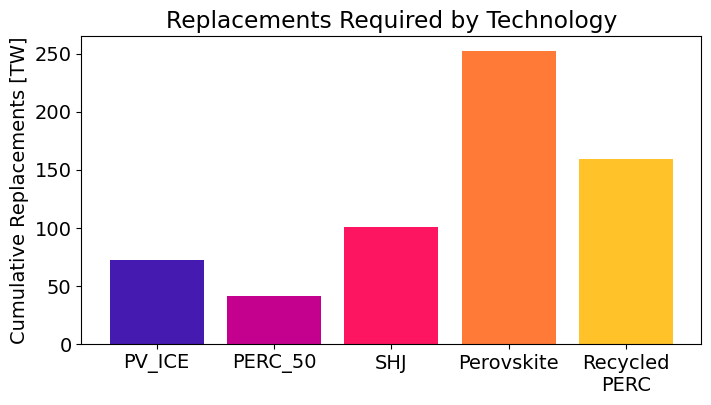

In [57]:
Additional_installs = cumu_installs.loc[2100]-global_projection.loc[2100,'World_cum']
plt.bar(scennames, Additional_installs/1e6, tick_label=scennames_labels, color=colorpalette)
#plt.legend(scennames)
plt.ylabel('Cumulative Replacements [TW]')
plt.title('Replacements Required by Technology')

# RESULTS: Virgin Material Demands

Text(0, 0.5, 'Virgin Material Requirements\n[billion tonnes]')

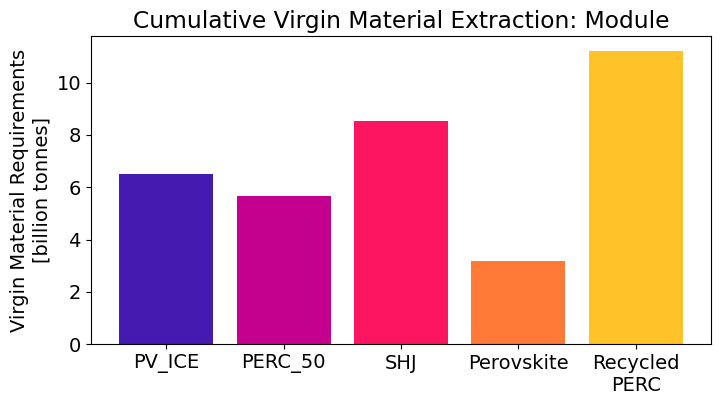

In [58]:
cumu_virgin_module = cc_cumu.filter(like='VirginStock_Module')
plt.bar(scennames, cumu_virgin_module.loc[2100]/1e9, tick_label=scennames_labels, color=colorpalette)
#plt.legend(scennames)
plt.title('Cumulative Virgin Material Extraction: Module')
plt.ylabel('Virgin Material Requirements\n[billion tonnes]')

(0.0, 11.768620191776137)

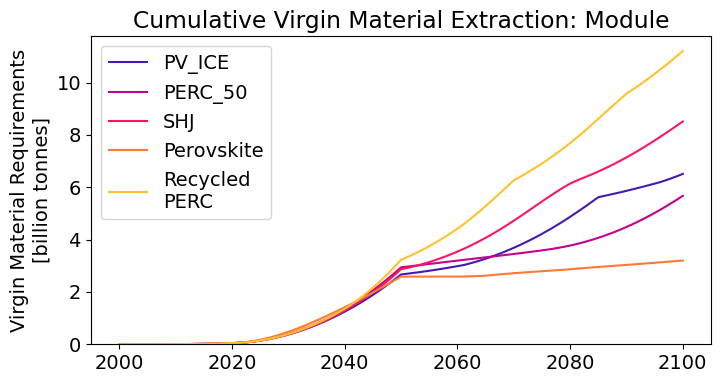

In [59]:
cumu_virgin_module = cc_cumu.filter(like='VirginStock_Module')
plt.plot(cumu_virgin_module/1e9)
plt.legend(scennames_labels)
plt.title('Cumulative Virgin Material Extraction: Module')
plt.ylabel('Virgin Material Requirements\n[billion tonnes]')
plt.ylim(0,)

(0.0, 246.67992773023929)

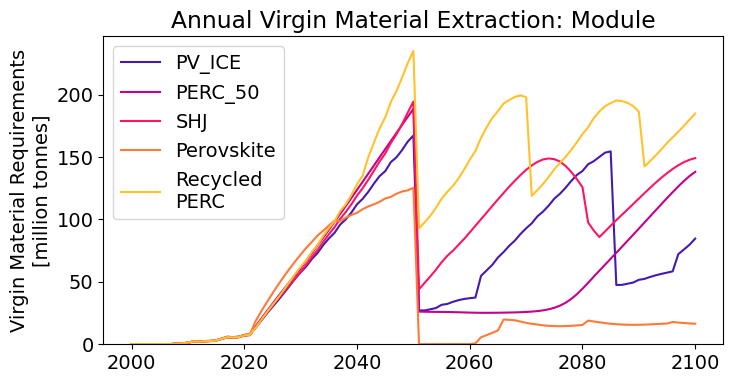

In [60]:
annual_virgin_module = cc_yearly.filter(like='VirginStock_Module')
plt.plot(annual_virgin_module/1e6)
plt.legend(scennames_labels)
plt.title('Annual Virgin Material Extraction: Module')
plt.ylabel('Virgin Material Requirements\n[million tonnes]')
plt.ylim(0,)

# RESULTS: Lifecycle Wastes

Text(0, 0.5, 'Lifecycle Wastes\n[million tonnes]')

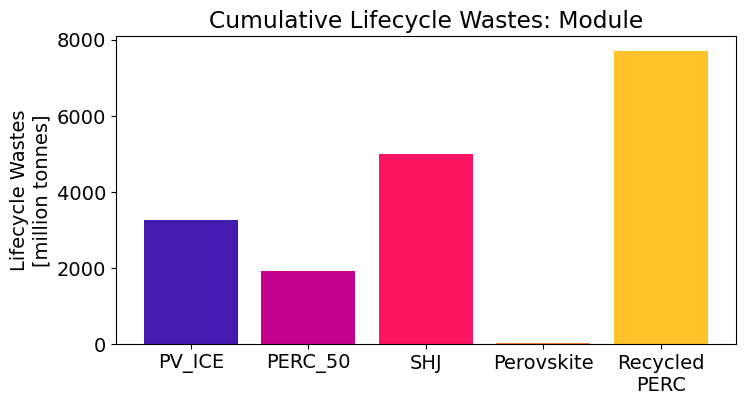

In [61]:
cumu_lifecycle_wastes = cc_cumu.filter(like='WasteAll_Module')

plt.bar(scennames, cumu_lifecycle_wastes.loc[2100]/1e6, 
        tick_label=scennames_labels, color=colorpalette)
#plt.legend(scennames)
plt.title('Cumulative Lifecycle Wastes: Module')
plt.ylabel('Lifecycle Wastes\n[million tonnes]')

# RESULTS: Energy

In [62]:
sim1.scenario['SHJ'].dataOut_e

mod_MFG   mod_Install  mod_OandM  mod_Repair   mod_Demount  \
0    5.133424e+10  5.251887e+07        0.0         0.0  0.000000e+00   
1    1.838934e+10  1.860921e+07        0.0         0.0  0.000000e+00   
2    2.235026e+10  2.237429e+07        0.0         0.0  0.000000e+00   
3    3.424444e+10  3.391656e+07        0.0         0.0  0.000000e+00   
4    7.015314e+10  6.875008e+07        0.0         0.0  0.000000e+00   
..            ...           ...        ...         ...           ...   
96   3.281818e+13  9.202929e+10        0.0         0.0  3.130569e+12   
97   3.351270e+13  9.397687e+10        0.0         0.0  3.262626e+12   
98   3.409147e+13  9.559987e+10        0.0         0.0  3.385084e+12   
99   3.454416e+13  9.686931e+10        0.0         0.0  3.502548e+12   
100  3.484826e+13  9.772207e+10        0.0         0.0  3.610513e+12   

     mod_Store  mod_Resell_Certify  mod_ReMFG_Disassembly  mod_Recycle_Crush  \
0          0.0                 0.0                    0.0       0.000000e+00   
1          0.0                 0.0                    0.0       1.419913e+00   
2          0.0                 0.0                    0.0       1.097105e+02   
3          0.0                 0.0                    0.0       1.342435e+03   
4          0.0                 0.0                    0.0       7.714372e+03   
..         ...                 ...                    ...                ...   
96         0.0                 0.0                    0.0       3.595438e+11   
97         0.0                 0.0                    0.0       3.689558e+11   
98         0.0                 0.0                    0.0       3.768092e+11   
99         0.0                 0.0                    0.0       3.829616e+11   
100        0.0                 0.0                    0.0       3.871006e+11   

     e_out_annual_[Wh]  
0         1.312654e+12  
1         1.774165e+12  
2         2.332674e+12  
3         3.189692e+12  
4         4.954058e+12  
..                 ...  
96        9.753769e+16  
97        9.789370e+16  
98        9.824971e+16  
99        9.860571e+16  
100       9.896172e+16  

[101 rows x 10 columns]

In [63]:
allenergy, energyGen, energy_demands = sim1.aggregateEnergyResults()

C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\main.py:1871: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\main.py:1871: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\main.py:1871: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

## Energy Generation
Check that they all produce the same amount of energy

(0.0, 103909.74394690627)

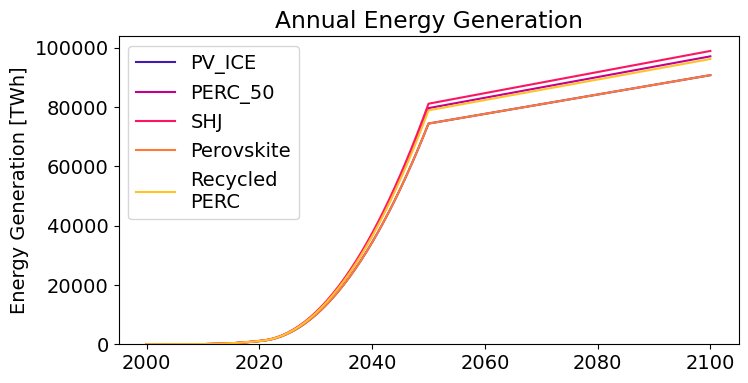

In [64]:
#energyGen = allenergy.filter(like='e_out_annual')
plt.plot(energyGen/1e12)
plt.legend(scennames_labels)
plt.title('Annual Energy Generation')
plt.ylabel('Energy Generation [TWh]')
plt.ylim(0,)

## Net Energy

In [65]:
e_annual_sumDemands = energy_demands.filter(like='demand_total')

(0.0, 4722.349712781299)

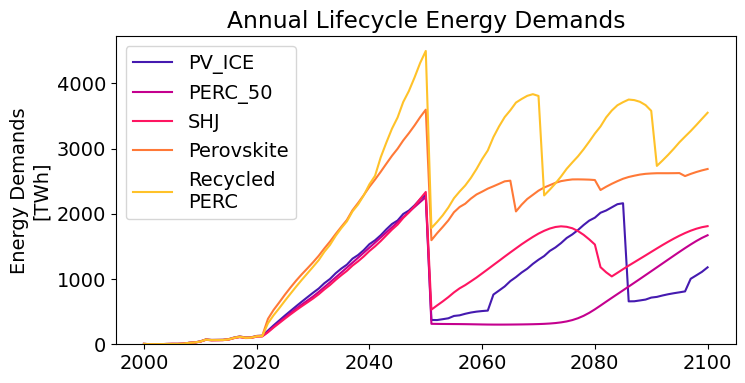

In [66]:
plt.plot(e_annual_sumDemands/1e12)
plt.legend(scennames_labels)
plt.title('Annual Lifecycle Energy Demands')
plt.ylabel('Energy Demands\n[TWh]')
plt.ylim(0,)

In [67]:
e_annual_sumDemands_cumu = e_annual_sumDemands.cumsum()

Text(0, 0.5, 'Cumulative Energy Demands\n[TWh]')

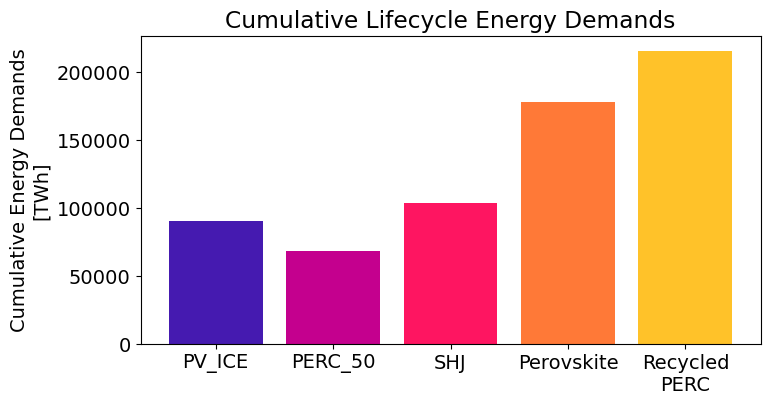

In [68]:
plt.bar(e_annual_sumDemands_cumu.columns, e_annual_sumDemands_cumu.loc[2100]/1e12, 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Cumulative Lifecycle Energy Demands')
plt.ylabel('Cumulative Energy Demands\n[TWh]')

In [69]:
energyGen_cumu = energyGen.cumsum()
energyGen_cumu.columns = e_annual_sumDemands_cumu.columns = scennames
netEnergy_cumu = energyGen_cumu.loc[[2100]] - e_annual_sumDemands_cumu.loc[[2100]]

In [70]:
e_annual_sumDemands_cumu.loc[[2100]]

PV_ICE       PERC_50           SHJ    Perovskite  RecycledPERC
year                                                                      
2100  9.067275e+16  6.878861e+16  1.036093e+17  1.781868e+17  2.156104e+17

In [71]:
netEnergy_cumu

PV_ICE       PERC_50           SHJ    Perovskite  RecycledPERC
year                                                                      
2100  4.872836e+18  5.242166e+18  5.306615e+18  4.785322e+18  5.045709e+18

In [102]:
netEnergy_cumu_norm = netEnergy_cumu/netEnergy_cumu.loc[2100,'PV_ICE']
netEnergy_cumu_norm_waterfall = netEnergy_cumu_norm-1
netEnergy_cumu_norm


PV_ICE   PERC_50      SHJ  Perovskite  Recycled\nPERC
year                                                       
2100     1.0  1.075794  1.08902     0.98204        1.035477

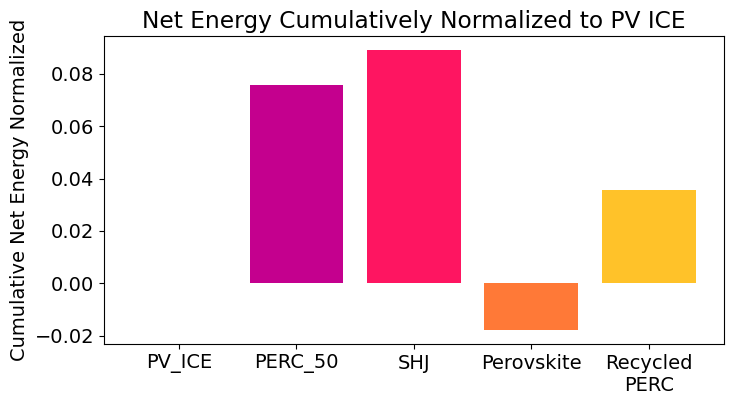

In [103]:
plt.bar(netEnergy_cumu.columns, netEnergy_cumu_norm_waterfall.loc[2100], 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Net Energy Cumulatively Normalized to PV ICE')
plt.ylabel('Cumulative Net Energy Normalized')
#plt.ylim(-0.026,0.005)
plt.plot(0.0, lw=2)

Text(0, 0.5, 'Cumulative Net Energy\n[TWh]')

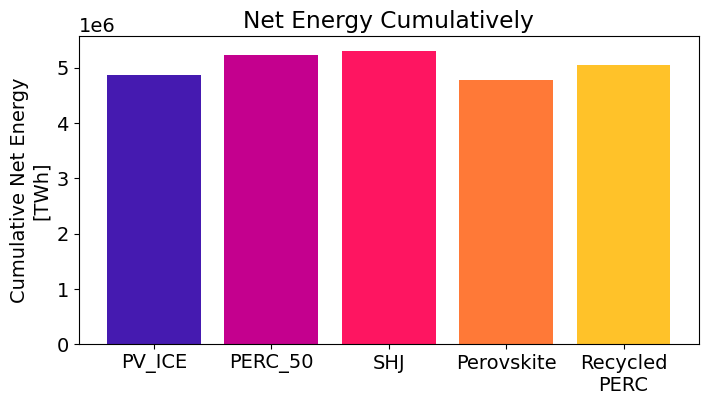

In [74]:
plt.bar(netEnergy_cumu.columns, netEnergy_cumu.loc[2100]/1e12, 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Net Energy Cumulatively')
plt.ylabel('Cumulative Net Energy\n[TWh]')

In [75]:
energyGen.columns = e_annual_sumDemands.columns = scennames
annual_net_energy = energyGen - e_annual_sumDemands

(2040.0, 2100.0)

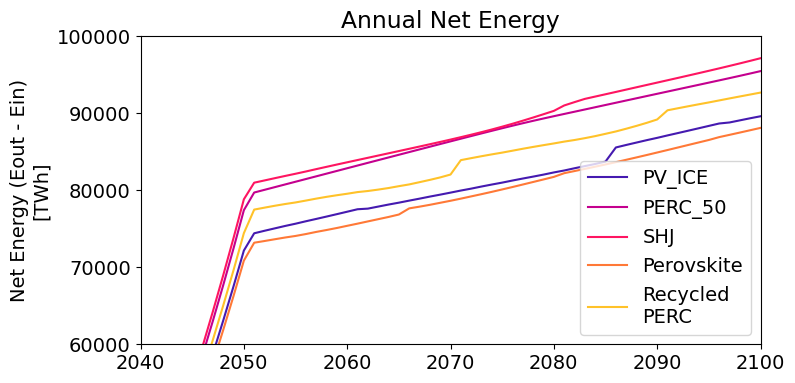

In [76]:
plt.plot(annual_net_energy/1e12)
plt.legend(scennames_labels)
plt.title('Annual Net Energy')
plt.ylabel('Net Energy (Eout - Ein)\n[TWh]')
plt.ylim(60000,100000)
plt.xlim(2040,2100)

# CE-TE Metric
Net Energy over Linear mass flow

In [77]:
#cumulatively
netEnergy_cumu.columns = cumu_virgin_module.columns = cumu_lifecycle_wastes.columns = scennames_labels

CETEmetric = (netEnergy_cumu.loc[2100]/1e6)/ (cumu_virgin_module.loc[2100]+ cumu_lifecycle_wastes.loc[2100])

Text(0, 0.5, 'Net Energy / Linear Mass \n[MWh/tonne]')

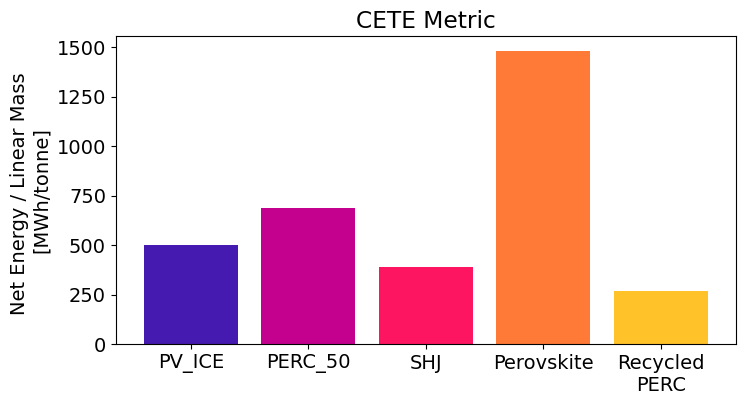

In [78]:
plt.bar(CETEmetric.index, CETEmetric, 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('CETE Metric')
plt.ylabel('Net Energy / Linear Mass \n[MWh/tonne]')

# EROI
Create single installation simulation to evaluate EROI of modules. Do one round of 2022 modules and one of 2050 modules.
## EROI 2022

In [79]:
single_deploy_2022 = pd.DataFrame(index=idx_temp, columns=['MW'], dtype=float)
single_deploy_2022['MW'] = 0.0
single_deploy_2022.loc[2022] = 100.0 #install a single 100 MW system

In [80]:
sim2 = PV_ICE.Simulation(name='sim2', path=testfolder)
for scen in scennames:
    sim2.createScenario(name=scen, massmodulefile=moduleFile_m, energymodulefile=moduleFile_e)
    for mat in range (0, len(MATERIALS)):
        matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
        matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
        sim2.scenario[scen].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

path = C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP\EnergyAnalysis


In [81]:
#use the settings from the first simulation to create the identical settings for sim2
for scen in scennames:
    sim2.scenario[scen].dataIn_m = sim1.scenario[scen].dataIn_m
    sim2.scenario[scen].dataIn_e = sim1.scenario[scen].dataIn_e
    for mat in MATERIALS:
        sim2.scenario[scen].material[mat].matdataIn_m = sim1.scenario[scen].material[mat].matdataIn_m
        sim2.scenario[scen].material[mat].matdataIn_e = sim1.scenario[scen].material[mat].matdataIn_e
        

In [82]:
sim2.scenario['Perovskite'].material['glass'].matdataIn_m

year  mat_virgin_eff  mat_massperm2  mat_MFG_eff  mat_MFG_scrap_Recycled  \
0    2000            60.0         8000.0         95.0                    80.0   
1    2001            60.0         8000.0         95.0                    80.0   
2    2002            60.0         8000.0         95.0                    80.0   
3    2003            60.0         8000.0         95.0                    80.0   
4    2004            60.0         8000.0         95.0                    80.0   
..    ...             ...            ...          ...                     ...   
96   2096            60.0        12500.0         99.0                   100.0   
97   2097            60.0        12500.0         99.0                   100.0   
98   2098            60.0        12500.0         99.0                   100.0   
99   2099            60.0        12500.0         99.0                   100.0   
100  2100            60.0        12500.0         99.0                   100.0   

     mat_MFG_scrap_Recycling_eff  mat_MFG_scrap_Recycled_into_HQ  \
0                           50.0                            20.0   
1                           50.0                            20.0   
2                           50.0                            20.0   
3                           50.0                            20.0   
4                           50.0                            20.0   
..                           ...                             ...   
96                          99.0                           100.0   
97                          99.0                           100.0   
98                          99.0                           100.0   
99                          99.0                           100.0   
100                         99.0                           100.0   

     mat_MFG_scrap_Recycled_into_HQ_Reused4MFG  mat_PG3_ReMFG_target  \
0                                         10.0                   0.0   
1                                         10.0                   0.0   
2                                         10.0                   0.0   
3                                         10.0                   0.0   
4                                         10.0                   0.0   
..                                         ...                   ...   
96                                       100.0                 100.0   
97                                       100.0                 100.0   
98                                       100.0                 100.0   
99                                       100.0                 100.0   
100                                      100.0                 100.0   

     mat_ReMFG_yield  ...  e_mod_MFG  e_mod_Install  e_mod_OandM  \
0               50.0  ...        NaN            NaN          NaN   
1               50.0  ...        NaN            NaN          NaN   
2               50.0  ...        NaN            NaN          NaN   
3               50.0  ...        NaN            NaN          NaN   
4               50.0  ...        NaN            NaN          NaN   
..               ...  ...        ...            ...          ...   
96              99.0  ...        NaN            NaN          NaN   
97              99.0  ...        NaN            NaN          NaN   
98              99.0  ...        NaN            NaN          NaN   
99              99.0  ...        NaN            NaN          NaN   
100             99.0  ...        NaN            NaN          NaN   

     e_mod_Repair  e_mod_Demount  e_mod_Demount_fuelfraction  \
0             NaN            NaN                         NaN   
1             NaN            NaN                         NaN   
2             NaN            NaN                         NaN   
3             NaN            NaN                         NaN   
4             NaN            NaN                         NaN   
..            ...            ...                         ...   
96            NaN            NaN                         NaN   
97            NaN    

In [83]:
#trim to start in 2000, this trims module and materials
#had to specify and end year, cannot use to extend
sim2.trim_Years(startYear=2000, endYear=2100)

Data trimed, years now encompass  2000  to  2100
Data trimed, years now encompass  2000  to  2100
Data trimed, years now encompass  2000  to  2100
Data trimed, years now encompass  2000  to  2100
Data trimed, years now encompass  2000  to  2100


In [84]:
#deployment projection for all scenarios
sim2.modifyScenario(scenarios=None,stage='new_Installed_Capacity_[MW]', value= single_deploy_2022['MW'], start_year=2000)


In [85]:
sim2.scenario['Perovskite'].dataIn_m.loc[19:25]

year  new_Installed_Capacity_[MW]    mod_eff  mod_reliability_t50  \
19  2019                          0.0  19.200000                 28.0   
20  2020                          0.0  20.000000                 33.0   
21  2021                          0.0  20.900000                 33.0   
22  2022                        100.0  17.900000                 14.0   
23  2023                          0.0  18.421429                 14.0   
24  2024                          0.0  18.942857                 14.0   
25  2025                          0.0  19.464286                 14.0   

    mod_reliability_t90  mod_degradation  mod_lifetime  mod_MFG_eff  \
19                 33.0             0.75          32.4         98.0   
20                 38.0             0.75          35.0         98.0   
21                 38.0             0.75          35.0         98.0   
22                 20.0             1.47          15.0         98.0   
23                 20.0             1.47          15.0         98.0   
24                 20.0             1.47          15.0         98.0   
25                 20.0             1.47          15.0         98.0   

    mod_Repair  mod_MerchantTail  ...  mod_EOL_pg1_landfill  \
19         0.0               0.0  ...                  60.0   
20         0.0               0.0  ...                  60.0   
21         0.0               0.0  ...                  60.0   
22         0.0               0.0  ...                   0.0   
23         0.0               0.0  ...                   0.0   
24         0.0               0.0  ...                   0.0   
25         0.0               0.0  ...                   0.0   

    mod_EOL_pg2_stored  mod_EOL_pg3_reMFG  mod_EOL_pg4_recycled  \
19                 0.0                0.0                  40.0   
20                 0.0                0.0                  40.0   
21                 0.0                0.0                  40.0   
22                 0.0              100.0                   0.0   
23                 0.0              100.0                   0.0   
24                 0.0              100.0                   0.0   
25                 0.0              100.0                   0.0   

    mod_EOL_reMFG_yield  mod_EOL_sp_reMFG_recycle  mod_EOL_pb1_landfill  \
19                  0.0                     100.0                  60.0   
20                  0.0                     100.0                  60.0   
21                  0.0                     100.0                  60.0   
22                 98.0                     100.0                   0.0   
23                 98.0                     100.0                   0.0   
24                 98.0                     100.0                   0.0   
25                 98.0                     100.0                   0.0   

    mod_EOL_pb2_stored  mod_EOL_pb3_reMFG  mod_EOL_pb4_recycled  
19                 0.0                0.0                  40.0  
20                 0.0                0.0                  40.0  
21                 0.0                0.0                  40.0  
22                 0.0              100.0                   0.0  
23                 0.0              100.0                   0.0  
24                 0.0              100.0                   0.0  
25                 0.0              100.0                   0.0  

[7 rows x 22 columns]

In [86]:
for scen in scennames:
    sim2.calculateFlows(scenarios=[scen],bifacialityfactors=bifiPathDict[scen])

>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  PV_ICE  =  1.1616105160956598  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  PV_ICE  =  14.67314025020167  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Rec

In [87]:
sim2_yearly, sim2_cumulative = sim2.aggregateResults()

In [88]:
allenergy2, energyGen2, energy_demands2 = sim2.aggregateEnergyResults()

C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\main.py:1871: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\main.py:1871: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\main.py:1871: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

In [89]:
allenergy2_cumu = allenergy2.cumsum()
energyGen2_cumu = energyGen2.cumsum()
energy_demands2_cumu = energy_demands2.cumsum()

In [118]:
energy_demands2_cumu_total = energy_demands2_cumu.filter(like='demand_total')
#energy_demands2_cumu_total

Text(0, 0.5, 'Energy Demands [Wh]')

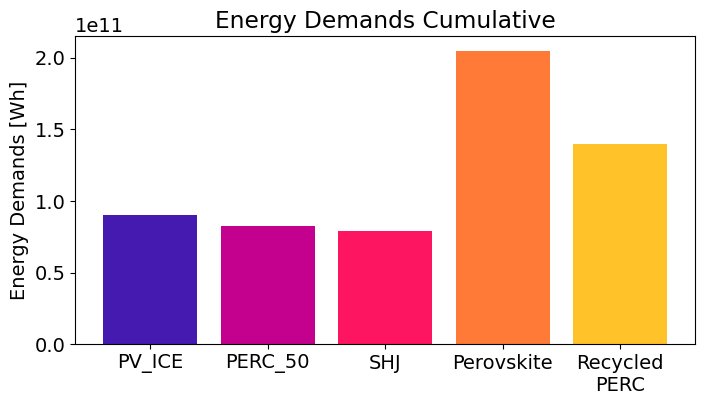

In [117]:
plt.bar(energy_demands2_cumu_total.columns, energy_demands2_cumu_total.loc[2100], 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Energy Demands Cumulative')
plt.ylabel('Energy Demands [Wh]')

In [91]:
energyGen2_cumu.columns=energy_demands2_cumu_total.columns=scennames_labels
eroi_2022 = energyGen2_cumu.iloc[100]/energy_demands2_cumu_total.iloc[100]
eroi_2022

PV_ICE            48.304084
PERC_50           96.026037
SHJ               52.557466
Perovskite         8.565442
Recycled\nPERC    19.822351
Name: 2100, dtype: float64

Text(0, 0.5, 'Arb.')

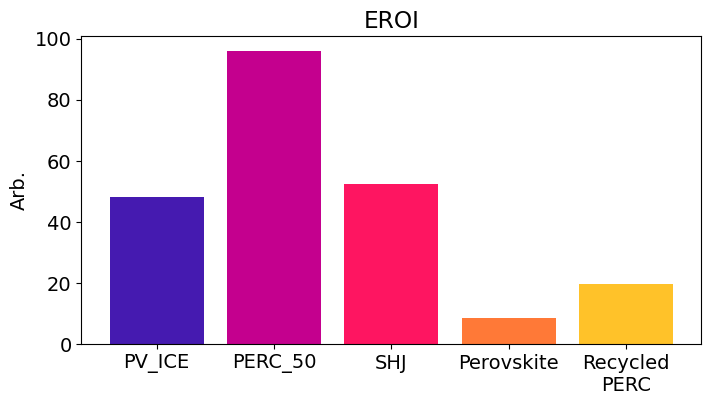

In [92]:
plt.bar(eroi_2022.index, eroi_2022, 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('EROI')
plt.ylabel('Arb.')

Text(0, 0.5, '[GWh]')

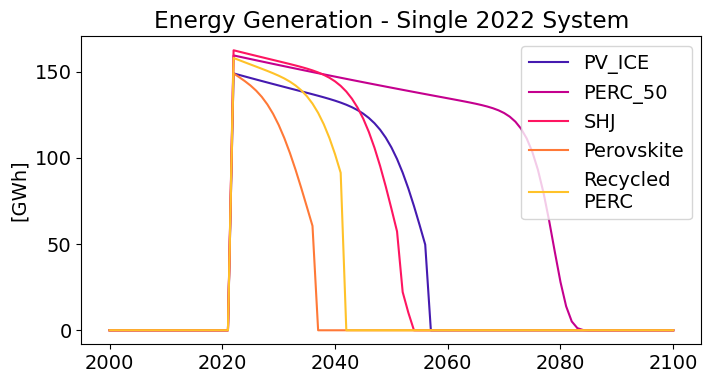

In [93]:
plt.plot(energyGen2/1e9)
plt.legend(scennames_labels)
plt.title('Energy Generation - Single 2022 System')
plt.ylabel('[GWh]')

## EROI of 2050 module

In [121]:

single_deploy_2050 = pd.DataFrame(index=idx_temp, columns=['MW'], dtype=float)
single_deploy_2050['MW'] = 0.0
single_deploy_2050.loc[2050] = 100.0 #install a single 100 MW system

In [122]:
sim3 = PV_ICE.Simulation(name='sim3', path=testfolder)
for scen in scennames:
    sim3.createScenario(name=scen, massmodulefile=moduleFile_m, energymodulefile=moduleFile_e)
    for mat in range (0, len(MATERIALS)):
        matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
        matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
        sim3.scenario[scen].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

path = C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP\EnergyAnalysis


In [123]:
#use the settings from the first simulation to create the identical settings for sim2
for scen in scennames:
    sim3.scenario[scen].dataIn_m = sim1.scenario[scen].dataIn_m
    sim3.scenario[scen].dataIn_e = sim1.scenario[scen].dataIn_e
    for mat in MATERIALS:
        sim3.scenario[scen].material[mat].matdataIn_m = sim1.scenario[scen].material[mat].matdataIn_m
        sim3.scenario[scen].material[mat].matdataIn_e = sim1.scenario[scen].material[mat].matdataIn_e
        

In [124]:
sim3.scenario['Perovskite'].material['glass'].matdataIn_m

year  mat_virgin_eff  mat_massperm2  mat_MFG_eff  mat_MFG_scrap_Recycled  \
0    2000            60.0         8000.0         95.0                    80.0   
1    2001            60.0         8000.0         95.0                    80.0   
2    2002            60.0         8000.0         95.0                    80.0   
3    2003            60.0         8000.0         95.0                    80.0   
4    2004            60.0         8000.0         95.0                    80.0   
..    ...             ...            ...          ...                     ...   
96   2096            60.0        12500.0         99.0                   100.0   
97   2097            60.0        12500.0         99.0                   100.0   
98   2098            60.0        12500.0         99.0                   100.0   
99   2099            60.0        12500.0         99.0                   100.0   
100  2100            60.0        12500.0         99.0                   100.0   

     mat_MFG_scrap_Recycling_eff  mat_MFG_scrap_Recycled_into_HQ  \
0                           50.0                            20.0   
1                           50.0                            20.0   
2                           50.0                            20.0   
3                           50.0                            20.0   
4                           50.0                            20.0   
..                           ...                             ...   
96                          99.0                           100.0   
97                          99.0                           100.0   
98                          99.0                           100.0   
99                          99.0                           100.0   
100                         99.0                           100.0   

     mat_MFG_scrap_Recycled_into_HQ_Reused4MFG  mat_PG3_ReMFG_target  \
0                                         10.0                   0.0   
1                                         10.0                   0.0   
2                                         10.0                   0.0   
3                                         10.0                   0.0   
4                                         10.0                   0.0   
..                                         ...                   ...   
96                                       100.0                 100.0   
97                                       100.0                 100.0   
98                                       100.0                 100.0   
99                                       100.0                 100.0   
100                                      100.0                 100.0   

     mat_ReMFG_yield  ...  e_mod_MFG  e_mod_Install  e_mod_OandM  \
0               50.0  ...        NaN            NaN          NaN   
1               50.0  ...        NaN            NaN          NaN   
2               50.0  ...        NaN            NaN          NaN   
3               50.0  ...        NaN            NaN          NaN   
4               50.0  ...        NaN            NaN          NaN   
..               ...  ...        ...            ...          ...   
96              99.0  ...        NaN            NaN          NaN   
97              99.0  ...        NaN            NaN          NaN   
98              99.0  ...        NaN            NaN          NaN   
99              99.0  ...        NaN            NaN          NaN   
100             99.0  ...        NaN            NaN          NaN   

     e_mod_Repair  e_mod_Demount  e_mod_Demount_fuelfraction  \
0             NaN            NaN                         NaN   
1             NaN            NaN                         NaN   
2             NaN            NaN                         NaN   
3             NaN            NaN                         NaN   
4             NaN            NaN                         NaN   
..            ...            ...                         ...   
96            NaN            NaN                         NaN   
97            NaN    

In [125]:
#deployment projection for all scenarios
sim3.modifyScenario(scenarios=None,stage='new_Installed_Capacity_[MW]', value= single_deploy_2050['MW'], start_year=2000)


In [126]:
#trim to start in 2000, this trims module and materials
#had to specify and end year, cannot use to extend
sim3.trim_Years(startYear=2000, endYear=2150)

Data trimed, years now encompass  2000  to  2150
Data trimed, years now encompass  2000  to  2150
Data trimed, years now encompass  2000  to  2150
Data trimed, years now encompass  2000  to  2150
Data trimed, years now encompass  2000  to  2150


In [142]:
sim3.scenario['Perovskite'].dataIn_e.tail(4)#loc[49:55]

year  e_mod_MFG  e_mod_Install  e_mod_OandM  e_mod_Repair  e_mod_Demount  \
147  2147     3320.0            9.5          0.0       10700.0         2360.0   
148  2148     3320.0            9.5          0.0       10700.0         2360.0   
149  2149     3320.0            9.5          0.0       10700.0         2360.0   
150  2150     3320.0            9.5          0.0       10700.0         2360.0   

     e_mod_Demount_fuelfraction  e_mod_Resell_Certify  e_mod_Store  \
147                       100.0                   0.2          0.0   
148                       100.0                   0.2          0.0   
149                       100.0                   0.2          0.0   
150                       100.0                   0.2          0.0   

     e_mod_ReMFG_Disassembly  e_mod_Recycle_Crush  
147                      1.1                670.0  
148                      1.1                670.0  
149                      1.1                670.0  
150                      1.1                670.0

In [148]:
#PV ICE currently set up to read in a csv of bifi factors, so generate files to read in 
#need to adjust for length to 2150
idx_temp_2150 = pd.RangeIndex(start=2000,stop=2151,step=1) #create the index
df_temp_2150 = pd.DataFrame(index=idx_temp_2150, columns=['bifi'], dtype=float)
bifiPathDict_2150={}

for f in bifiFactors.keys(): #loop over module types
    bifi_2150 = df_temp_2150.copy() #copy of df
    bifi_2150['bifi'] = bifiFactors[f] #assign column
    bifipath_2150 = os.path.join(testfolder,'bifi_'+str(f)+'.csv') #create file path
    bifi_2150.to_csv(path_or_buf=bifipath_2150, index_label='year') #create file
    bifiPathDict_2150[str(f)] = bifipath_2150
    #append bifi path to dict? or list?


In [149]:
for scen in scennames:
    sim3.calculateFlows(scenarios=[scen], bifacialityfactors=bifiPathDict_2150[scen])

>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  PV_ICE  =  1.049692271917671  tonnes.
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  PV_ICE  =  11.526020144738922  tonnes.


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  aluminium_frames
>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Rec

In [150]:
sim3_yearly, sim3_cumulative = sim3.aggregateResults()

In [151]:
allenergy3, energyGen3, energy_demands3 = sim3.aggregateEnergyResults()

C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\main.py:1871: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\main.py:1871: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\main.py:1871: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

In [153]:
allenergy3_cumu = allenergy3.cumsum()
energyGen3_cumu = energyGen3.cumsum()
energy_demands3_cumu = energy_demands3.cumsum()

In [154]:
energy_demands3_cumu_total = energy_demands3_cumu.filter(like='demand_total')
#energy_demands3_cumu_total

Text(0, 0.5, 'Energy Demands [Wh]')

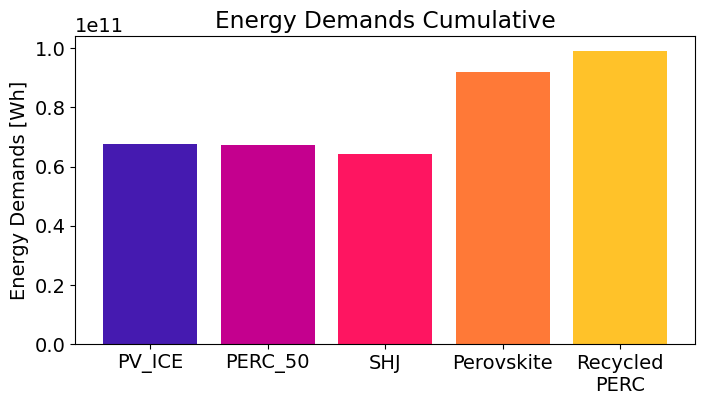

In [155]:
plt.bar(energy_demands3_cumu_total.columns, energy_demands3_cumu_total.loc[2150], 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Energy Demands Cumulative')
plt.ylabel('Energy Demands [Wh]')

In [156]:
energyGen3_cumu.columns = energy_demands3_cumu_total.columns = scennames_labels
eroi_2050 = energyGen3_cumu.loc[2150]/energy_demands3_cumu_total.loc[2150]
eroi_2050

PV_ICE             70.225423
PERC_50           117.851083
SHJ                64.801650
Perovskite         19.075806
Recycled\nPERC     27.903383
Name: 2150, dtype: float64

Text(0, 0.5, 'Arb.')

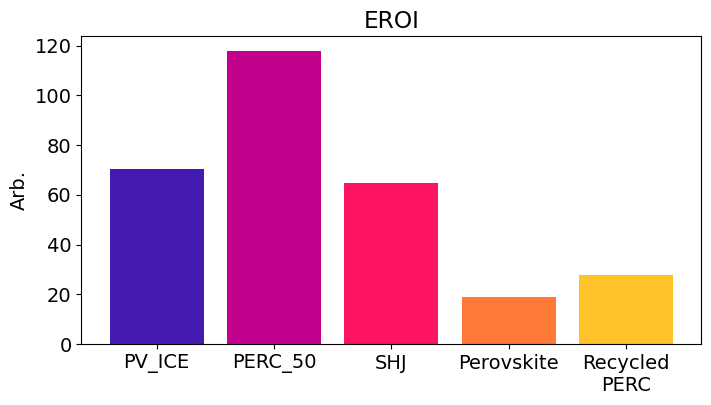

In [157]:
plt.bar(eroi_2050.index, eroi_2050, 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('EROI')
plt.ylabel('Arb.')

Text(0, 0.5, '[GWh]')

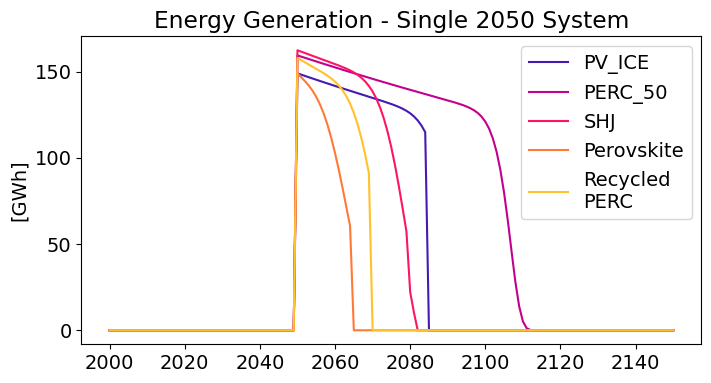

In [158]:
plt.plot(energyGen3/1e9)
plt.legend(scennames_labels)
plt.title('Energy Generation - Single 2050 System')
plt.ylabel('[GWh]')

# To Do
- energy requirements on a per MW installed for a single install, what is MFG
- Y axis = normalized net energy of perovskites, x axis = remanufacturing energy variation, maybe add recycling Just change one variable 

- EROI
- CETE Metric

lowest nergy = remfg
mid energy = recycle
high energy = virgin mfg